In [1]:
import collections
import math
import os
import zipfile

import numpy as np
from six.moves import urllib
import tensorflow as tf


In [2]:
url = 'http://mattmahoney.net/dc/'


def maybe_download(filename, expected_bytes):
    """Download a file if not present, and make sure it's the right size."""
    if not os.path.exists(filename):
        filename, _ = urllib.request.urlretrieve(url + filename, filename)
    statinfo = os.stat(filename)
    if statinfo.st_size == expected_bytes:
        print('Found and verified', filename)
    else:
        print(statinfo.st_size)
        raise Exception('Failed to verify ' + filename + '. Can you get to it with a browser?')
    return filename

filename = maybe_download('text8.zip', 31344016)


def read_data(filename):
    ''' zip 파일에 포함된 텍스트 파일을 읽어서 단어 리스트 생성. 포함된 파일은 1개. 
    zip 파일은 30mb, txt 파일은 100mb. '''
    with zipfile.ZipFile(filename) as f:
        names = f.namelist()                # ['text8']
        contents = f.read(names[0])         # 크기 : 100,000,000바이트
        text = tf.compat.as_str(contents)   # 크기 : 100,000,000
        return text.split()                 # 갯수 : 17005207


vocabulary = read_data(filename)
print('Data size', len(vocabulary))   

# .을 기준으로 리스트 여러개로 나눈후에 space로 다시 리스트로 나눈다.
# I like you. you like me -> [[I like you], [you like me]] -> [[[I] [like] [you]], ... ]

Found and verified text8.zip
Data size 17005207


In [3]:
vocabulary_size = 50000


def build_dataset(words, n_words):
    # count : [['UNK', -1], ('the', 1061396), ('of', 593677), ('and', 416629), ...]
    # 크기는 50,000개. UNK가 들어 있고, -1을 뺐으니까 처음에 전달된 크기 사용.
    # 빈도가 높은 5만개 추출.
    # count에 포함된 마지막 데이터는 ('hif', 9). 9번 나왔는데 드물다고 얘기할 수 있는지는 의문.
    unique = collections.Counter(words)             # 중복 단어 제거
    orders = unique.most_common(n_words - 1)        # 단어에 대한 빈도 계산. 갯수를 지정하지 않으면 전체 계산.
    count = [['UNK', -1]]
    count.extend(orders)

    # dictionary : (UNK, 0) (the, 1) (of, 2) (and, 3) (one, 4) (in, 5) (a, 6) (to, 7)
    # 내용을 보면 단어에 번호를 매겼다는 것을 알 수 있다.
    dictionary = {}
    for word, _ in count:
        dictionary[word] = len(dictionary)

    # 위의 코드는 결국 0부터 1씩 증가하는 인덱스를 len(dictionary)로 표현했기 때문에
    # enumerate 함수를 사용한 아래처럼 표현할 수 있다. len(dictionary)는 코드가 모호하다.
    # for i, (word, _) in enumerate(count):
    #     dictionary[word] = i

    # dictionary = {word: i for i, (word, _) in enumerate(count)}

    # 단어 전체에 대해 인덱스 매핑. data는 단어를 가리키는 인덱스 리스트가 된다.
    # 인덱스를 계산하기 위해 딕셔너리 대신 리스트를 사용할 수도 있고, 얼핏 보면 좋아보일 수도 있다.
    # 리스트를 사용하면 이진 검색을 적용해야
    data = []
    for word in words:
        if word in dictionary:          # word가 dictionary에 존재한다면
            index = dictionary[word]
        else:
            index = 0                   # UNK는 0번째에 위치
            count[0][1] += 1            # 갯수 : 418391
        data.append(index)

    # dictionary와 reversed_dictionary 내용
    # 일련번호로 된 key와 value가 의미 있을까? 리스트로 처리하면 되지 않을까?
    # (UNK, 0) (the, 1) (of, 2) (and, 3) (one, 4) (in, 5) (a, 6) (to, 7) (zero, 8) (nine, 9) (two, 10)
    # (0, UNK) (1, the) (2, of) (3, and) (4, one) (5, in) (6, a) (7, to) (8, zero) (9, nine) (10, two)
    # reversed_dictionary = dict(zip(dictionary.values(), dictionary.keys()))

    # reversed_dictionary는 0부터 시작하는 일련번호를 갖기 때문에 딕셔너리로 만들면 오히려 어렵고 불편하다.
    # 아래 코드는 리스트와 같다는 것을 증명하는 코드.
    # a = list(dictionary.values())
    # print(type(a), len(a))
    # print(a[0], a[-1])
    #
    # b = list(range(len(dictionary.values())))
    # print(b[0], b[-1])
    #
    # assert a == b

    # reversed_dictionary 대신 key로 구성된 리스트 반환.
    # [(0, UNK) (1, the) (2, of) (3, and) (4, one)]에서 인덱스를 제외하고 구성한 리스트.
    # 원본에서는 dictionary 변수를 반환하고 있는데, 사용하지 않기 때문에 삭제.
    return data, count, list(dictionary.keys())

# data : 단어에 대한 인덱스만으로 구성된 리스트
# count : 단어와 빈도 쌍으로 구성된 리스트. 중요한 변수이지만, 이번 코드에서는 사용 안함.
# ordered_words : 빈도에 따라 정렬된 단어 리스트
data, count, ordered_words = build_dataset(vocabulary, vocabulary_size)

# print('Most common words (+UNK)', count[:5])
# print('Sample data', data[:10], [ordered_words[i] for i in data[:10]], sep='\n')
# print('-'*50)
  # 사용하지 않는 변수 삭제

# [출력 결과]
# Most common words (+UNK) [['UNK', 418390], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
# Sample data
# [5234, 3081, 12, 6, 195, 2, 3134, 46, 59, 156]
# ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against']




In [4]:
def word_numbering(vocabulary, number_of_n_words=50000):
    """
    Arguments:
    vocabulary -- a list of words you want to train the word2vec
    number_of_n_words -- number of most frequent n words in the vocabulary you want to set
    
    Returns:
    int_voc -- a list of vocabulary that is mapped into integer-valeud index
    word_to_int -- python dict mapping words in the vocabulary into an integer-valued index
    int_to_word -- python dict mapping integer-valued index to words
    most_frequent_n_words -- a list with pairs of n most frequent words with its frequency -> [(word, frequency)]
    """
    word_count = collections.Counter(vocabulary)
    most_frequent_n_words = word_count.most_common(number_of_n_words - 1)
            
    word_to_int = {'UNK': 0} # set 0 as unknown token
    for word, _ in most_frequent_n_words:
        word_to_int[word] = len(word_to_int)
    
    int_to_word = {v: k for k, v in word_to_int.items()} # reverse dict of word_to_int


    count = 0
    int_voc = []

    for word in vocabulary:
        if word in word_to_int: # if word is in n most frequent words
            int_voc.append(word_to_int[word]) #. change the word into the corresponding integer
        else:
            int_voc.append(0) # not in the n most frequent word.
            count += 1   # number of words that are not in n most frequent words
 
    most_frequent_n_words.insert(0, ('UNK', count))
    #most_frequent_n_words = np.insert(most_frequent_n_words, 0,('UNK', count),axis=0)
            
    return int_voc, word_to_int, int_to_word, most_frequent_n_words
    
# del vocabulary

In [5]:
# For the test
int_voc, word_to_int, int_to_word, most_frequent_n_words = word_numbering(vocabulary)

In [49]:
def compute_f(most_frequent_n_words):
    """
    parameter passing이 문제가 될시 most_frequent_n_words를 passing 하지않고 global로 사용?
    Arguments:
    
    Returns:
    """
    list_to_numpy = np.array(most_frequent_n_words)
    divided_words = list_to_numpy[:, 0]
    divided_frequency = list_to_numpy[:, 1].astype(np.int)
    sum_frquency = np.sum(divided_frequency)
    assert ( sum_frquency.shape == ())
    divided_frequency = divided_frequency / sum_frquency
    
    
    
    return divided_frequency

In [50]:
divided_frequency = compute_f(most_frequent_n_words) # 필요한 코드 지우지말자

In [51]:
def subsampling(divided_frequency,  t=0.00001):
    """
    Arguments:
    divided_frequency -- a numpy arrayof the frequency of each word, shape of (vocabulary_size,)
    t -- threshold 
    
    Returns:
    p_w -- probability of dropping the word
    """
    p_w = (divided_frequency - t )/divided_frequency - np.sqrt(t / divided_frequency)
    p_w[p_w < 0] = 0
    assert (p_w.shape == divided_frequency.shape)
    
    return p_w

In [67]:
def noise_distribution(divided_frequency):
    f = np.power(divided_frequency, 0.75)
    neg_p_w = f/ sum(f)
    return neg_p_w

In [68]:
divided_frequency

array([  2.46036993e-02,   6.24159412e-02,   3.49114833e-02, ...,
         5.29249659e-07,   5.29249659e-07,   5.29249659e-07])

In [107]:
noise = (noise_distribution(divided_frequency)) # 필요한 코드 지우지말자 

In [111]:
def create_mini_batch(int_voc, batch_size, window_size, num_context_word, start_x, start_y):
    """
    Create mini batch size of batch_size with each batch containing num_target_word training examples.
    
    Arguments:
    data -- a list of vocabulary that is mapped into integer-valeud index
    batch_size -- size of batch in stochastic gradient descent
    window_size -- size of window around the target word.
    num_context_word --
    
    Returns:
    start_x
    start_y
    """
    int_voc = [int_voc] # this will deleted if the input includes punctuation
    
    assert (start_y < len(int_voc[start_x]))

    for i in range(batch_size / num_context_word):
        start = max(0, start_y - window_size) 
        end = min(start_y + window_size, len(int_voc[start_x]) - 1)
    
    

In [112]:
# Step 3: skip-gram 모델에 사용할 학습 데이터를 생성할 함수 작성

# 원본에서는 data_index를 전역변수로 처리했는데, 여기서는 매개변수와 반환값으로 변경했다.
# data 변수 또한 전역변수였는데, 첫 번째 매개변수로 전달하도록 변경했다.
def generate_batch(data, batch_size, num_skips, skip_window, data_index):
    ''' Stochastic Gradient Descent 알고리즘에 사용할 minibatch 생성.
    :param data : 단어 인덱스 리스트
    :param batch_size : SGD 알고리즘에 적용할 데이터 갯수. 한 번에 처리할 크기.
    :param num_skips : context window에서 구축할 (target, context) 쌍의 갯수.
    :param skip_window : skip-gram 모델에 사용할 윈도우 크기.
         1이라면 목표 단어(target) 양쪽에 1개 단어이므로 context window 크기는 3이 된다. (단어, target, 단어)
         2라면 5가 된다. (단어 단어 target 단어 단어)
    :param data_index : 첫 번째 context window에 들어갈 data에서의 시작 위치.
    '''
    
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window

    temp = 'batch_size {}, num_skips {}, skip_window {}, data_index {}'

    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size), dtype=np.int32)

    # span은 assert에 기술한 코드 때문에 항상 num_skips보다 크다.
    span = 2 * skip_window + 1                      # context = skip_window + target + skip_window
    assert span > num_skips

    buffer = collections.deque(maxlen=span)
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)   # 다음 단어 인덱스로 이동. len(data) = 17005207


    # batch_size는 num_skips로 나누어 떨어지기 때문에 정확하게 batch_size만큼 반복
    for i in range(batch_size // num_skips):

        # 여기서는 항상 skip_window는 1, num_skips는 2의 값을 갖는다.
        targets = list(range(span))     # 1. 0부터 span-1까지의 정수로 채운 다음
        targets.pop(skip_window)        # 2. skip_window번째 삭제
        np.random.shuffle(targets)      # 3. 난수를 사용해서 섞는다.

        # batch : target 단어만 들어가고, num_skips만큼 같은 단어가 중복된다.
        # labels : target을 제외한 단어만 들어가고, num_skips만큼 중복될 수 있다.
        start = i * num_skips
        batch[start:start+num_skips] = buffer[skip_window]

        # span이 큰 값이기 때문에 targets에 포함된 모든 값을 사용하지 않을 수 있다.
        # buffer는 numpy 데이터가 아니라서 슬라이스 연산 불가. 어쩔 수 없이 반복문 사용.
        # numpy 배열을 사용하면서 마지막에 있는 num_skips 갯수만큼 사용하는 것이 나을 수도 있다.
        for j in range(num_skips):
            labels[start+j] = buffer[targets[j]]
            # print(targets[j], '**')     # (2, 0), (0, 2), (0, 2), (0, 2)

        # 새로운 요소가 들어가면서 가장 먼저 들어간 데이터 삭제
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)

    data_index = (data_index + len(data) - span) % len(data)
    return batch, labels, data_index


# generate_batch 함수 테스트. 아래 코드는 뒤쪽에서 사용하지 않는다.
batch, labels, data_index = generate_batch(data, batch_size=1, num_skips=1, skip_window=1, data_index=0)
for i in range(1):
    print('{} {} -> {} {}'.format(batch[i],     ordered_words[batch[i]],
                                  labels[i], ordered_words[labels[i]]))
# [출력 결과]
# 3081 originated -> 12 as
# 3081 originated -> 5234 anarchism
# 12 as -> 6 a
# 12 as -> 3081 originated
# 6 a -> 195 term
# 6 a -> 12 as
# 195 term -> 2 of
# 195 term -> 6 a

3081 originated -> 12 as


In [113]:
batch, labels, data_index = generate_batch(data, batch_size=1, num_skips=1, skip_window=1, data_index=0)



In [114]:
for i in range(1):
    print('{} {} -> {} {}'.format(batch[i],     ordered_words[batch[i]],
                                  labels[i], ordered_words[labels[i]]))

3081 originated -> 12 as


In [129]:
def parameter_initialization(vocabulary_size, projection_size):
    """
    Initialization method -- he initialization. 
    
    Argument:
    vocabulary_size -- the size of the vocabulary
    projection_size -- the dimension of hidden layer in NN
    
    Return:
    parameters -- a python dictionary containing weights W_in, b_in, W_out, b_out
    """
    
    np.random.seed(0)
    parameters = {}
    
    parameters['W_in'] = np.random.randn(vocabulary_size, projection_size) *  np.sqrt(2 / vocabulary_size) 
    # parameters["b_in"] = np.zeros((projection_size, 1))
    
    parameters['W_out'] = np.random.randn(projection_size, vocabulary_size) *  np.sqrt(2 / projection_size)
    # parameters['b_out'] = np.zeros((vocabulary_size, 1))
    
    assert (parameters['W_in'].shape == (vocabulary_size, projection_size)) 
    assert (parameters['W_out'].shape == (projection_size, vocabulary_size))
    
        
    return parameters

In [130]:
def sigmoid(z):
    """
    Arguments:
    Z -- numpy array of any shape
    
    Returns:
    sig -- numpy array of sigmoid(z)
    """
    
    sig = 1/(1 + np.exp(-z))
    
    return sig

In [131]:
def compute_cost(batch, labels, parameters, is_pos):
    """
    Arguments:
    batch -- 1로 가정하자.
    labels --
    parameters --
    is_pos -- if "pos", compute np.multiply(out, hidden), if "neg" compute -np.multiply(out, hidden)
    Returns:
    """
    assert(batch.shape==labels.shape)
    W_in = parameters["W_in"]
    W_out = parameters["W_out"]
    
    hidden = W_in.T[:,batch]
    out = W_out[:, labels]
    if is_pos == "pos":
        cost = np.sum(np.multiply(out, hidden),axis=0)
    elif is_pos == "neg":
        cost = - np.sum(np.multiply(out, hidden),axis=0)
    cost = sigmoid(cost)
    cost = -np.log(cost)
    
    assert (hidden.shape == (W_in.shape[1], len(batch)))
    assert (out.shape == (W_in.shape[1], len(batch)))
    assert (cost.shape == (len(batch),))
    
    return cost

In [132]:
def feed_forward_NN(batch, labels, k, parameters):
    """    
    Arguments:
    batch-- input of Neural Network of shape (batch_size, ) size = 1 로 가정하자
    labels -- a list containing the true labeled output of shape (batch_size, )
    k -- number of negative sampling
    parameters -- python dictionary containing weights W_in, b_in, W_out, b_out
    
    Returns:
    cost -- the cost function of the NN
    caches -- used in backpropagation
    """
    positive = compute_cost(batch, labels, parameters, "pos")
    for i, label_word in enumerate(batch):
        # This will be replaced with the noise distriution Pn(W)
            
        negative_samples = np.random.choice(np.arange(0,50000), k, p=noise) # changed to noise distribution
        neg_batch = np.array([label_word for _ in range (k)])
        negs = negative_samples # batch size가 바뀌면 수정되야하는 부분
        
        assert (negative_samples.shape == neg_batch.shape)
        
        neg = np.sum(compute_cost(neg_batch, negative_samples, parameters, "neg"))
        positive[i] = positive[i] + neg 
        
    cost = np.mean(positive)
    assert(cost.shape == ())
    return cost, negs

# negative sampling 도 return 해야 할것 같다? ?


In [133]:
def backpropagation(batch, labels, negs, parameters, learning_rate=0.01):
    """
    Arguments:
    
    Returns:
    grads -- the value of gradient descent
    """
    W_in = parameters['W_in']
    W_out = parameters['W_out']
    hidden = W_in.T[:, batch] # shape: (100, 1)
    
    out = W_out[:, labels] # shape: (100,1)
    neg_out = W_out[:, negs] # shape: (100, k)
    
    k = len(negs)
    
    out_sig = sigmoid(np.sum(np.multiply(out, hidden),axis=0)) - 1
    out_neg_sig = sigmoid(np.sum(np.multiply(neg_out, hidden),axis=0, keepdims=True)) # (1,100) 여기 뭔가 문제있는데?
    
    assert(out_neg_sig.shape == (1, k))
    s = np.sum(out_neg_sig * neg_out, axis=1, keepdims=True)
    t = np.multiply(out_sig, out)
    assert(s.shape==t.shape)
    grads_in = s+t
    
    grads_out = (out_sig) * hidden  # hidden (100, 1)
    grads_neg_out = (out_neg_sig) *  hidden
            
    # update should be done at the same time 
    W_in[batch,:] = W_in[batch,:] - learning_rate * grads_in.T
    W_out[:, labels] = W_out[:, labels] - learning_rate * grads_out
    W_out[:, negs] = W_out[:, negs] - learning_rate * grads_neg_out
    
    return parameters

In [134]:
def negative_sampling(divided_frequency):
    
    pass

In [135]:
def update_parameters(parameters, grads, learning_rate):
    """
    Updates the parameters based on adaGradientDescent with learning rate decay
    Arguments:
    parameters -- python dict containing parameters before the updates
    grads -- python dict containing the gradient
    Returns:
    parameters -- python dict containing updated parameters 
    """
    pass
    

In [136]:
def train(vocabulary, projection_size, num_of_n_words, epoch, learning_rate):
    
    vocabulary_size = 50000
    parameters = parameter_initialization(vocabulary_size, projection_size)
    
    # int_voc, word_to_int, int_to_word, most_frequent_n_words = word_numbering(vocabulary)
    data, count, ordered_words = build_dataset(vocabulary, vocabulary_size)
    
    data_index = 0
    for i in range(epoch):
        batch, labels, data_index = generate_batch(data, 1,1, 1, data_index)
        cost, negs = feed_forward_NN(batch,labels, 20, parameters)
        # learning_rate = learning_rate / (1 + 0.01* epcoh_num) 
        parameters = backpropagation(batch, labels, negs, parameters, learning_rate)
        
        if i % 100 == 0:
            print("The cost at:", i,"th iteration is",cost)
    
    return parameters

In [137]:
parameters=train(vocabulary, 1000, 50000, 100000, 0.1) # was 1000000

The cost at: 0 th iteration is 14.5307643565
The cost at: 100 th iteration is 14.4312445013
The cost at: 200 th iteration is 14.5706253466
The cost at: 300 th iteration is 14.5392946359
The cost at: 400 th iteration is 14.5387046662
The cost at: 500 th iteration is 14.4032625717
The cost at: 600 th iteration is 14.4573689631
The cost at: 700 th iteration is 14.5383602963
The cost at: 800 th iteration is 14.4974388679
The cost at: 900 th iteration is 14.5722572304
The cost at: 1000 th iteration is 14.5013080045
The cost at: 1100 th iteration is 14.5452733379
The cost at: 1200 th iteration is 14.5066198633
The cost at: 1300 th iteration is 14.5368279246
The cost at: 1400 th iteration is 14.3681231471
The cost at: 1500 th iteration is 14.3876193609
The cost at: 1600 th iteration is 13.9723267447
The cost at: 1700 th iteration is 14.5727134308
The cost at: 1800 th iteration is 14.5844080188
The cost at: 1900 th iteration is 13.9135269378
The cost at: 2000 th iteration is 14.5811869309
The 

The cost at: 17000 th iteration is 11.0909157585
The cost at: 17100 th iteration is 8.44301786325
The cost at: 17200 th iteration is 7.42485077218
The cost at: 17300 th iteration is 4.85373988188
The cost at: 17400 th iteration is 14.6336983724
The cost at: 17500 th iteration is 5.87908707393
The cost at: 17600 th iteration is 9.13168544895
The cost at: 17700 th iteration is 2.26938827152
The cost at: 17800 th iteration is 3.59136502005
The cost at: 17900 th iteration is 7.35252121195
The cost at: 18000 th iteration is 6.61197915749
The cost at: 18100 th iteration is 3.42969077959
The cost at: 18200 th iteration is 8.21470094796
The cost at: 18300 th iteration is 9.05962416112
The cost at: 18400 th iteration is 5.91713115524
The cost at: 18500 th iteration is 5.17346922444
The cost at: 18600 th iteration is 8.11547014245
The cost at: 18700 th iteration is 8.29664665709
The cost at: 18800 th iteration is 2.80161666214
The cost at: 18900 th iteration is 8.14413438913
The cost at: 19000 t

The cost at: 33800 th iteration is 6.25562220951
The cost at: 33900 th iteration is 4.76186825151
The cost at: 34000 th iteration is 3.60901069417
The cost at: 34100 th iteration is 5.99066429493
The cost at: 34200 th iteration is 1.17901322597
The cost at: 34300 th iteration is 3.10198555059
The cost at: 34400 th iteration is 4.9757491465
The cost at: 34500 th iteration is 1.56021426839
The cost at: 34600 th iteration is 5.35163497582
The cost at: 34700 th iteration is 3.10490171621
The cost at: 34800 th iteration is 14.5770538163
The cost at: 34900 th iteration is 4.19225317522
The cost at: 35000 th iteration is 4.34862016138
The cost at: 35100 th iteration is 5.67187244584
The cost at: 35200 th iteration is 4.83533586694
The cost at: 35300 th iteration is 4.1650258879
The cost at: 35400 th iteration is 7.20512508665
The cost at: 35500 th iteration is 5.08539169125
The cost at: 35600 th iteration is 6.28502897503
The cost at: 35700 th iteration is 5.83982185788
The cost at: 35800 th 

The cost at: 50600 th iteration is 3.36006423602
The cost at: 50700 th iteration is 3.63385209578
The cost at: 50800 th iteration is 7.0052651014
The cost at: 50900 th iteration is 1.34280127121
The cost at: 51000 th iteration is 7.63528238001
The cost at: 51100 th iteration is 7.61106946564
The cost at: 51200 th iteration is 5.60484580712
The cost at: 51300 th iteration is 7.86416563315
The cost at: 51400 th iteration is 8.42290397873
The cost at: 51500 th iteration is 7.03895487731
The cost at: 51600 th iteration is 7.61681575051
The cost at: 51700 th iteration is 6.0758323253
The cost at: 51800 th iteration is 14.4875020779
The cost at: 51900 th iteration is 14.5855762013
The cost at: 52000 th iteration is 14.6465564046
The cost at: 52100 th iteration is 4.4403483618
The cost at: 52200 th iteration is 1.72080016764
The cost at: 52300 th iteration is 6.59792492541
The cost at: 52400 th iteration is 4.99005304341
The cost at: 52500 th iteration is 14.1521868108
The cost at: 52600 th i

The cost at: 67400 th iteration is 5.02344798649
The cost at: 67500 th iteration is 5.15207133168
The cost at: 67600 th iteration is 4.331018323
The cost at: 67700 th iteration is 14.6051844878
The cost at: 67800 th iteration is 6.77634411635
The cost at: 67900 th iteration is 4.12780632378
The cost at: 68000 th iteration is 4.25923972337
The cost at: 68100 th iteration is 6.66546728808
The cost at: 68200 th iteration is 3.25915352709
The cost at: 68300 th iteration is 5.06049617321
The cost at: 68400 th iteration is 0.346084506563
The cost at: 68500 th iteration is 3.06839232047
The cost at: 68600 th iteration is 14.23508781
The cost at: 68700 th iteration is 6.03241521887
The cost at: 68800 th iteration is 4.02674325728
The cost at: 68900 th iteration is 3.51966497416
The cost at: 69000 th iteration is 8.99936124964
The cost at: 69100 th iteration is 2.40832875039
The cost at: 69200 th iteration is 3.99248046645
The cost at: 69300 th iteration is 1.47676947583
The cost at: 69400 th i

The cost at: 84200 th iteration is 7.91783163412
The cost at: 84300 th iteration is 6.99485078571
The cost at: 84400 th iteration is 5.60635625949
The cost at: 84500 th iteration is 1.62786835754
The cost at: 84600 th iteration is 2.82596728178
The cost at: 84700 th iteration is 2.95910202107
The cost at: 84800 th iteration is 4.86768340468
The cost at: 84900 th iteration is 3.0022345078
The cost at: 85000 th iteration is 3.78707157952
The cost at: 85100 th iteration is 14.5851527583
The cost at: 85200 th iteration is 3.02863249124
The cost at: 85300 th iteration is 5.35930061916
The cost at: 85400 th iteration is 0.619121794619
The cost at: 85500 th iteration is 4.57797498883
The cost at: 85600 th iteration is 1.84550990079
The cost at: 85700 th iteration is 6.4936154337
The cost at: 85800 th iteration is 5.58771125953
The cost at: 85900 th iteration is 3.50053174531
The cost at: 86000 th iteration is 2.99393826583
The cost at: 86100 th iteration is 1.85874600169
The cost at: 86200 th

In [138]:
final_embeddings = parameters['W_in']

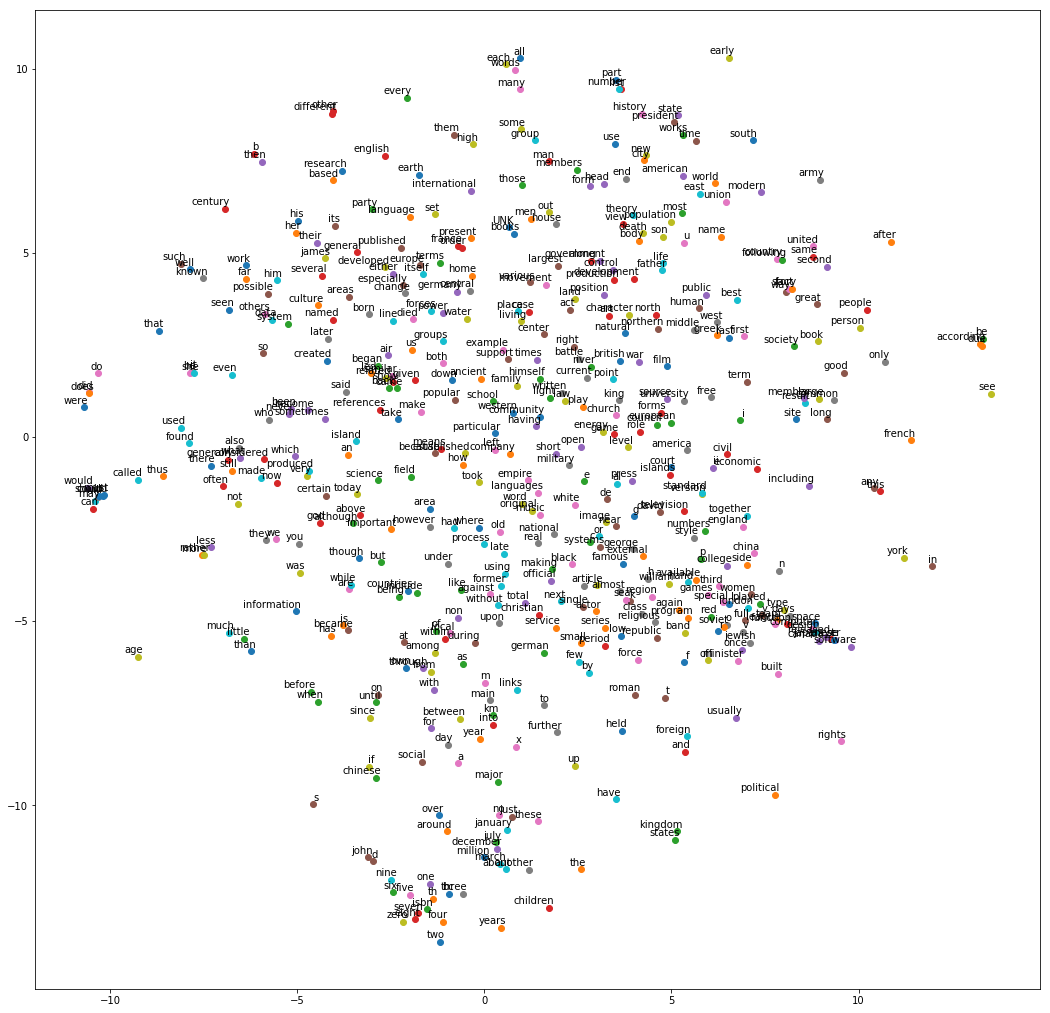

In [139]:
# Step 6: embeddings 시각화

def plot_with_labels(low_dim_embs, labels, filename='tsne.png'):
    assert low_dim_embs.shape[0] >= len(labels), 'More labels than embeddings'

    plt.figure(figsize=(18, 18))        # in inches

    # 원본 코드.
    # 해당 좌표에 점을 표시하고, 오른쪽/하단 정렬로 단어를 표시한다.
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i]

        plt.scatter(x, y)
        plt.annotate(label,
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')

    # 재구성한 코드
    # for (x, y), label in zip(low_dim_embs, labels):
    #     plt.scatter(x, y)
    #     plt.annotate(label,
    #                  xy=(x, y),
    #                  xytext=(5, 2),
    #                  textcoords='offset points',
    #                  ha='right',
    #                  va='bottom')

    plt.savefig(filename)

try:
    from sklearn.manifold import TSNE
    import matplotlib.pyplot as plt

    # low_dim_embs 내부 갯수와 n_components가 같아야 한다.
    # n_components : 차원. default는 2.
    # perplexity : 가장 가까운 이웃 갯수. 보통 5~50. default는 30.
    # n_iter : 최적화에 사용할 반복 횟수. 최소 200. default는 1000.
    # init : embedding 초기화 방법. random과 pca 중에서 선택. pca가 보다 안정적. default는 random.
    tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)

    # plot 갯수. 50000개의 embeddings로부터 앞쪽 일부만 사용.
    # low_dim_embs에는 변환된 좌표 x, y가 들어있다.
    plot_only = 500
    low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only])     # (500, 2)
    labels = ordered_words[:plot_only]                                  # 재구성한 코드
    # labels = [ordered_words[i] for i in range(plot_only)]             # 원본 코드

    plot_with_labels(low_dim_embs, labels)

except ImportError:
    print('Please install sklearn, matplotlib, and scipy to show embeddings.')


In [128]:
final_embeddings

array([[-0.09349713, -0.06828373, -0.15419762, ..., -0.08641302,
        -0.25734738, -0.24067809],
       [-0.09340445, -0.09978277, -0.11379935, ..., -0.08755492,
        -0.2243336 , -0.19427569],
       [-0.00713968, -0.29235106, -0.15544482, ...,  0.07339006,
        -0.12651281, -0.30640554],
       ..., 
       [-0.00339214, -0.00096241,  0.00574523, ...,  0.01445995,
        -0.01059498, -0.00634089],
       [ 0.01436376, -0.01019686,  0.00727192, ...,  0.01046948,
        -0.00287574, -0.00837307],
       [-0.02335021, -0.01477897,  0.00078421, ..., -0.00180235,
        -0.02845664, -0.00427574]])